# Geared, five-bar example

## Defining parameters

In this example we explore the use of a geared, five bar mechanism.

We define the parameters below, links 1 (the ground) through 5, along with their accompanying pin joints. Our coupler point is  defined as an offset along link 4, protruding at an angle from the link's orientation:

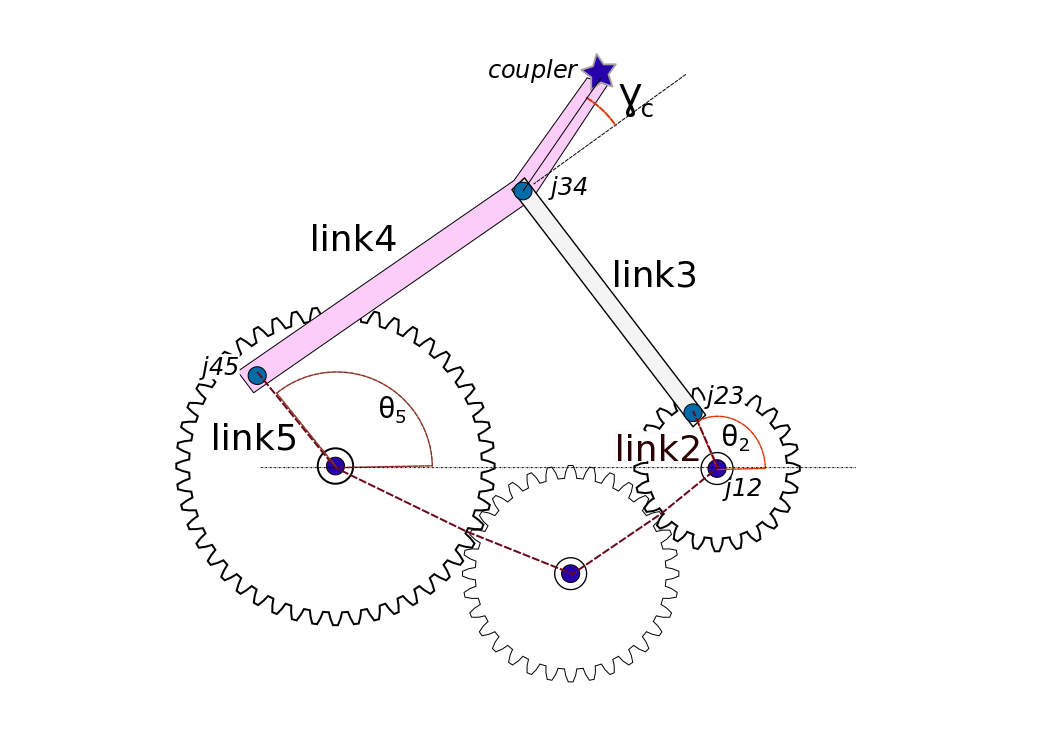

In [1]:
%matplotlib inline # Allow plots to appear in iPython

import numpy as np
from matplotlib.pyplot import *  #Lazy...
import os

from IPython.core.display import Image # Import function to display premade figure

#Import handy utility functions:
from LinkageUtilities import arcpoints, circcirc, coupler, grashof


Image(filename="Geared5BarNotation.png")

We know from the number of links and constraints that a five bar mechanism has <b>two</b> degrees of freedom. However, if we constrain the rotation of input crank (link 2) to link 5 by gearing them together, we have one degree of freedom and can plot the resulting coupler curve. 

## Loading in linkage

Load initial configuration assuming input joint is first and working around loop in series. Last line gives coupler location, which is assumed on link4. (You can flip mechanism to switch input/output, making it on link3).

In [2]:
pointsdata = np.loadtxt('InitialJointsGeared5Bar.txt')
initjoints = pointsdata[0:5,:]
initcoupler = pointsdata[5,:]

## Specify range of angles to rotate input, and gear ratio

Note that range can be negative and can be more than one revolution. Gearratio is negative if gears mesh directly, positive if using a belt or if you have an idler in between.

In [3]:
thetarange = -6.0*np.pi   
#thetarange = -0.5*np.pi 
gearratio = -2      #input gear rotations per output rotation
#Specify number steps to take
numsteps = 60

## Find lengths of the links

12 is length of link2 between joint12 and joint23, and so forth...

numpy.linalg.norm() computes the norm of a matrix; in this case it's just the square root of the sum of squares :-)

In [4]:
d12 = initjoints[1,:]-initjoints[0,:]
l2 = np.linalg.norm(d12)
d23 = initjoints[2,:]-initjoints[1,:]
l3 = np.linalg.norm(d23)
d34 = initjoints[3,:]-initjoints[2,:]
l4 = np.linalg.norm(d34)
d54 = initjoints[3,:]-initjoints[4,:]  #from output to joint45
l5 = np.linalg.norm(d54)
dc4 = initcoupler - initjoints[2,:]    #coupler to joint34
lc = np.linalg.norm(dc4)

## Add geared constraint

With a 5 bar, we need to keep input and output synchronized. Get input and output angles of initial configuration.
Use arctan2(deltay,deltax) for unambiguous sign convention.

In [5]:
theta2start = np.arctan2(d12[1],d12[0])
theta5start = np.arctan2(d54[1],d54[0])
theta2end = theta2start + thetarange
theta5end = theta5start + thetarange/gearratio

In [6]:
# Find the angle gammac between link4 and coupler
gamma1 = np.arctan2(-d34[1],-d34[0])
gamma2 = np.arctan2(dc4[1],dc4[0])
gammac = gamma2-gamma1

## Calculate initial position

Use circcirc() to see which solution for joint34 matches the one we've started with.
This determines which 'assembly' we have. If neither solution matches, something went wrong...
Use numpy.allclose() to check if negligible difference.

In [7]:
joint34 = circcirc(initjoints[1,:],l3,initjoints[3,:],l4)
if(np.allclose(joint34[0,:],initjoints[2,:])):
    assembly = 0
elif(np.allclose(joint34[1,:],initjoints[2,:])):
    assembly = 1
else:
    print('Hmmm, neither solution matches the input point...')

In [8]:
# Use Arcpoints() to get the positions of joint23,and joint45
joints23 = arcpoints(initjoints[0,:],l2,theta2start,theta2end,numsteps)
joints45 = arcpoints(initjoints[4,:],l5,theta5start,theta5end,numsteps)

In [9]:
# For each joint23 location, find the corresponding
# joint34 and coupler locations
joints34 = np.zeros((numsteps,2),float)
couplerpts = np.zeros((numsteps,2),float)
for i in range(0,numsteps):   
    intersects = circcirc(joints23[i,:],l3,joints45[i,:],l4)
    joints34[i,:] = intersects[assembly,:]
    couplerpts[i,:] = coupler(joints45[i,:],joints34[i,:],lc,gammac)

## Plot 

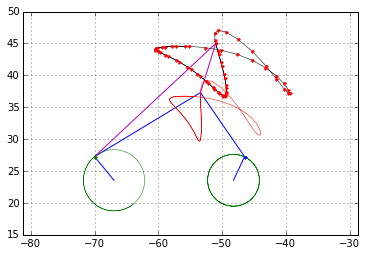

In [10]:
figure()            #if you want to start a new figure
clf()
grid(True)
axes().set_aspect('equal', 'datalim')  #square and limited by data

# Plot the initial configuration in blue, with magenta lines to coupler
plot(initjoints[:,0],initjoints[:,1],'b')
plot((initjoints[2,0],initcoupler[0]),(initjoints[2,1],initcoupler[1]),'m')
plot((initjoints[3,0],initcoupler[0]),(initjoints[3,1],initcoupler[1]),'m')

#Plot the various points - may want to modify this depending
# on what effects we are looking for.
# Currently plots a fat dot at start of angle range 
# numpy.plot() works conveniently for lists of 'x' and 'y' values.
plot(joints23[:,0],joints23[:,1],color = 'g',linewidth=0.5)
plot(joints23[0,0],joints23[0,1],'.')
plot(joints45[:,0],joints45[:,1],color = 'g',linewidth=0.5)
plot(joints45[0,0],joints45[0,1],'.')
plot(joints34[:,0],joints34[:,1],color = 'r',linewidth=0.5)
plot(couplerpts[:,0],couplerpts[:,1],color = 'k',linewidth=0.5)
plot(couplerpts[:,0],couplerpts[:,1],'.')

#Save a PDF of the plot 
savefig('Geared5BarPlot.pdf')

# Open file for writing joint and coupler points data
# in format that Excel, Matlab, Numpy, etc. can read.
# If we are not sure where we are writing:
#print("Data written: " + os.getcwd() + "/CircCirc4BarPoints.txt\n")   
Table = np.column_stack((joints23,joints34,joints45,couplerpts))
f_handle = file('Geared5BarOutput.txt', 'w')
headerstring = "joint23(x,y), joint34(x,y),   joint45(x,y),     coupler(x,y)"
np.savetxt(f_handle,Table,header=headerstring,delimiter='\t',newline='\n',fmt='%4.2f')
f_handle.close()